Pronóstico de la popularidad de libros (scikit-learn)
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/predictive-analytics/blob/master/10-logreg-R-books.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/predictive-analytics/blob/master/10-logreg-R-books.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/predictive-analytics/blob/master/LICENSE)  
[Readme](https://github.com/jdvelasq/predictive-analytics/blob/master/readme.md)

In [2]:
sms_raw = open('data/oreilly.csv').readlines()
sms_raw

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 5173: invalid start byte

In [26]:
# Carga y verificación de los datos
ranks <- read.csv('data/oreilly.csv', stringsAsFactors = FALSE)
str(ranks)

'data.frame':	100 obs. of  5 variables:
 $ IP_Family : chr  "9780596000271.IP" "9781565923928.IP" "9780596007126.IP" "9780596009205.IP" ...
 $ BOOK.title: chr  "Programming Perl, 3E" "Javascript: The Definitive Guide, 3E" "Head First Design Patterns" "Head First Java, 2E" ...
 $ BOOK.ISBN : num  9.78e+12 9.78e+12 9.78e+12 9.78e+12 9.78e+12 ...
 $ Rank      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Long.Desc.: chr  "Perl is a powerful programming language that  has grown in popularity since it first appeared in 1988. The firs"| __truncated__ "JavaScript is a powerful scripting language that can be embedded directly in HTML. It allows you to create dyna"| __truncated__ "You're not alone.<br />\n<br />\nAt any given moment, somewhere in the world someone struggles with the same so"| __truncated__ "Learning a complex new language is no easy task especially when it s an object-oriented computer programming la"| __truncated__ ...


# Metodología

Un árbol de modelos, es similar al arbol de regresión pero la salida de cada nodo es un modelo de regresión lineal. Haciendo la misma analogía con la figura anterior, la salida del nodo azul será calculada mediante el modelo de regresión:


$$y = \theta_0 + \theta_1 x_1 + \theta_2 x_2$$


estimado con los patrones de entrenamiento pertenecientes a la región azul.


# Entrenamiento del modelo

In [27]:
#
# carga la libreria para text mining
#
library(tm)
#
# La clasificación se basa únicamente en la descripción
# y no se tiene en cuenta el título.
#
documents <- data.frame(doc_id = ranks$BOOK.ISBN, text = ranks$Long.Desc.) 
row.names(documents) <- 1:nrow(documents)
#
# Crea el corpus y limpia el documento.
#
corpus <- Corpus(DataframeSource(documents))
corpus <- tm_map(corpus, tolower)
corpus <- tm_map(corpus, stripWhitespace)
corpus <- tm_map(corpus, removeWords, stopwords('english'))
#
# Crea la matriz de términos
#
dtm <- DocumentTermMatrix(corpus)
#
# Obtiene los regresores y la variable independiente.
# La matriz de términos del documento se convierte en
# una matriz numérica para poder realizar la regresión.
#
x <- as.matrix(dtm) 
y <- rev(1:100)  # 100, 99, ...
#

Este problema será resuelto como un problema de clasificación. Para ello, se pronosticará si un libro está en el top 50 o no. Nótese que también se podrían formularse otras agrupaciones como el top 10, top 20, etc.

In [36]:
#
# Semilla del generador de aleatorios.
#
set.seed(1)      
#
# Regresión con regularización.
#
library(glmnet)
#
# La variable y indica si el libro pertence (1) o no pertenece (2)
# al top 50 de los libros. A continuación se genera un vector con
# 50 unos y 50 ceros.
#
y <- rep(c(1, 0), each = 50)
#
# Crea un data.frame vacío para almacenar los resultados
# de la regresión para diferentes parámetros.
#
performance <- data.frame()
#
# Itera sobre diferentes valores de lambda.
#
for (i in 1:50) 
{
    #
    # Divide aleatoriamente el conjunto de datos
    # en una muestra para el entrenamiento y otra
    # para prueba
    #
    indices <- sample(1:100, 80) 
    training.x <- x[indices, ] 
    training.y <- y[indices]
    #
    test.x <- x[-indices, ] 
    test.y <- y[-indices]
    #
    # Realiza la regresión logística para diferentes 
    # valores de lambda.
    #    
    for (lambda in c(0.0001, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.5, 1)) 
    {
        #
        # Realiza la regresión.
        #
        glm.fit <- glmnet(training.x, training.y, family = 'binomial')
        #
        # Pronóstico para la muestra de entrenamiento
        #
        predicted.y <- predict(glm.fit, test.x, s = lambda) 
        #
        # Convierte el valor pronósticado en 0=no pertenece, 1=si pertenece.
        #
        predicted.y = ifelse(predicted.y > 0, 1, 0)
        #
        # Métrica de error
        #
        error.rate <- mean(predicted.y != test.y)
        #
        # Almacena el resultado
        #
        performance <- rbind(performance, data.frame(Lambda = lambda, Iteration = i, ErrorRate = error.rate))
    } 
}

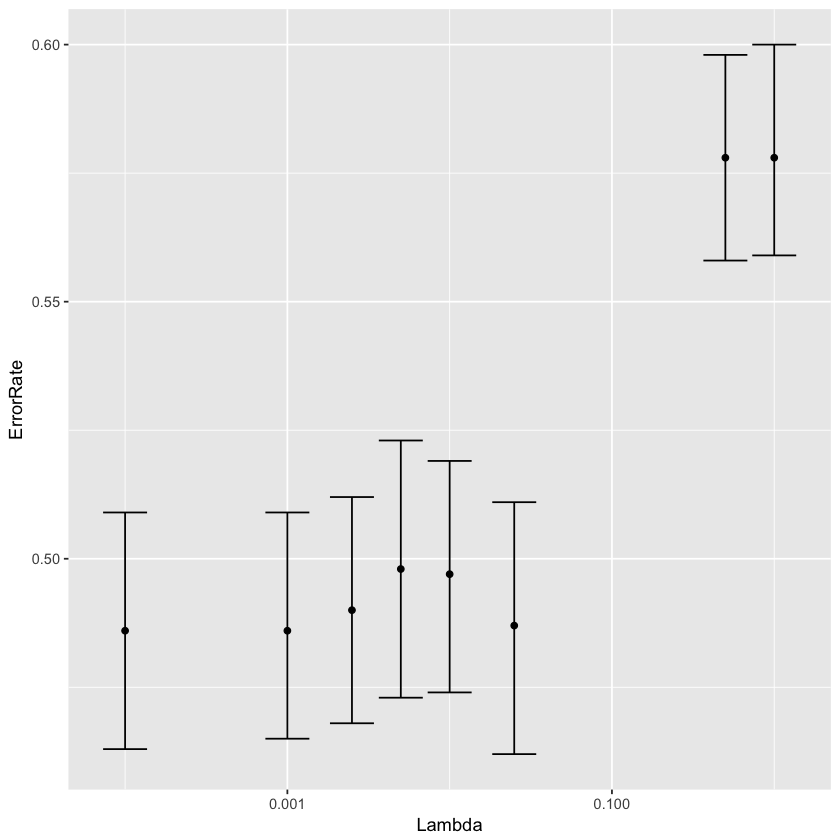

In [37]:
#
# El resultado de la siguiente gráfica muestra que se obtendría un
# mejor modelo para valores pequeños de lambda
#
ggplot(performance, aes(x = Lambda, y = ErrorRate)) + stat_summary(fun.data = 'mean_cl_boot', geom = 'errorbar') + stat_summary(fun.data = 'mean_cl_boot', geom = 'point') + scale_x_log10()

In [28]:
#
# Semilla del generador de aleatorios.
#
set.seed(1)      
#
# Regresión con regularización.
#
library(glmnet)
#
# Crea un data.frame vacío para almacenar los resultados
# de la regresión para diferentes parámetros.
#
performance <- data.frame()
#
# Itera sobre diferentes valores de lambda.
#
for (lambda in c(0.1, 0.25, 0.5, 1, 2, 5)) 
{
    for (i in 1:50) 
    {
        #
        # Divide aleatoriamente el conjunto de datos
        # en una muestra para el entrenamiento y otra
        # para prueba
        #
        indices <- sample(1:100, 80) 
        training.x <- x[indices, ] 
        training.y <- y[indices]
        #
        test.x <- x[-indices, ] 
        test.y <- y[-indices]
        #
        # Realiza la regresión.
        #
        glm.fit <- glmnet(training.x, training.y)
        #
        # Pronóstico para la muestra de entrenamiento
        #
        predicted.y <- predict(glm.fit, test.x, s = lambda) 
        #
        # Raíz del error cuadrático medio.
        #
        rmse <- sqrt(mean((predicted.y - test.y) ^ 2))
        #
        # Almacena el resultado
        #
        performance <- rbind(performance, data.frame(Lambda = lambda, Iteration = i, RMSE = rmse))
    } 
}

In [28]:
#
# Semilla del generador de aleatorios.
#
set.seed(1)      
#
# Regresión con regularización.
#
library(glmnet)
#
# Crea un data.frame vacío para almacenar los resultados
# de la regresión para diferentes parámetros.
#
performance <- data.frame()
#
# Itera sobre diferentes valores de lambda.
#
for (lambda in c(0.1, 0.25, 0.5, 1, 2, 5)) 
{
    for (i in 1:50) 
    {
        #
        # Divide aleatoriamente el conjunto de datos
        # en una muestra para el entrenamiento y otra
        # para prueba
        #
        indices <- sample(1:100, 80) 
        training.x <- x[indices, ] 
        training.y <- y[indices]
        #
        test.x <- x[-indices, ] 
        test.y <- y[-indices]
        #
        # Realiza la regresión.
        #
        glm.fit <- glmnet(training.x, training.y)
        #
        # Pronóstico para la muestra de entrenamiento
        #
        predicted.y <- predict(glm.fit, test.x, s = lambda) 
        #
        # Raíz del error cuadrático medio.
        #
        rmse <- sqrt(mean((predicted.y - test.y) ^ 2))
        #
        # Almacena el resultado
        #
        performance <- rbind(performance, data.frame(Lambda = lambda, Iteration = i, RMSE = rmse))
    } 
}

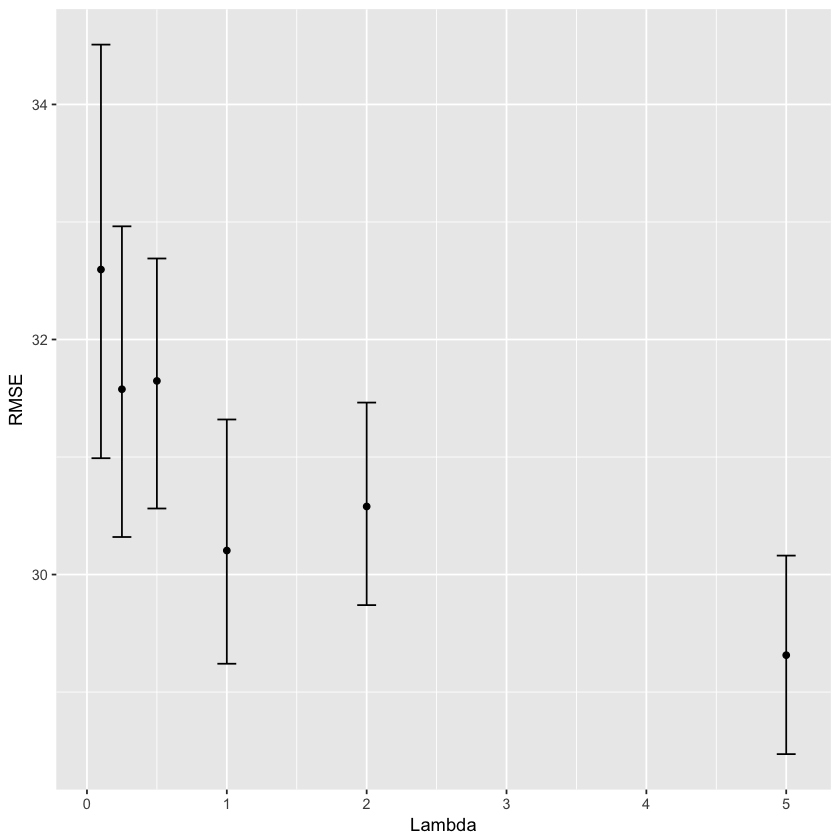

In [34]:
# install.packages('Hmisc)
library(ggplot2)
ggplot(performance, aes(x = Lambda, y = RMSE)) + stat_summary(fun.data = 'mean_cl_boot', geom = 'errorbar') + stat_summary(fun.data = 'mean_cl_boot', geom = 'point')

In [3]:
# conjuntos de entrenamiento y prueba
wine_train <- wine[1:3750, ]
wine_test <- wine[3751:4898, ]

In [4]:
# Se estima un árbol de regresión
# install.packages("rpart")
library(rpart)

In [5]:
# la calidad es función de todas las variables
# del data.frame
m.rpart <- rpart(quality ~ ., data = wine_train)
m.rpart

n= 3750 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 3750 3140.06000 5.886933  
   2) alcohol< 10.85 2473 1510.66200 5.609381  
     4) volatile.acidity>=0.2425 1406  740.15080 5.402560  
       8) volatile.acidity>=0.4225 182   92.99451 4.994505 *
       9) volatile.acidity< 0.4225 1224  612.34560 5.463235 *
     5) volatile.acidity< 0.2425 1067  631.12090 5.881912 *
   3) alcohol>=10.85 1277 1069.95800 6.424432  
     6) free.sulfur.dioxide< 11.5 93   99.18280 5.473118 *
     7) free.sulfur.dioxide>=11.5 1184  879.99920 6.499155  
      14) alcohol< 11.85 611  447.38130 6.296236 *
      15) alcohol>=11.85 573  380.63180 6.715532 *

**Ejercicio.--** Cómo se interpreta la figura anterior?

In [6]:
summary(m.rpart) 

Call:
rpart(formula = quality ~ ., data = wine_train)
  n= 3750 

          CP nsplit rel error    xerror       xstd
1 0.17816211      0 1.0000000 1.0005029 0.02388807
2 0.04439109      1 0.8218379 0.8226476 0.02237304
3 0.02890893      2 0.7774468 0.7885924 0.02214391
4 0.01655575      3 0.7485379 0.7601107 0.02098534
5 0.01108600      4 0.7319821 0.7458587 0.02047927
6 0.01000000      5 0.7208961 0.7446964 0.02038302

Variable importance
             alcohol              density            chlorides 
                  38                   23                   12 
    volatile.acidity total.sulfur.dioxide  free.sulfur.dioxide 
                  12                    7                    6 
           sulphates                   pH       residual.sugar 
                   1                    1                    1 

Node number 1: 3750 observations,    complexity param=0.1781621
  mean=5.886933, MSE=0.8373493 
  left son=2 (2473 obs) right son=3 (1277 obs)
  Primary splits:
      alco

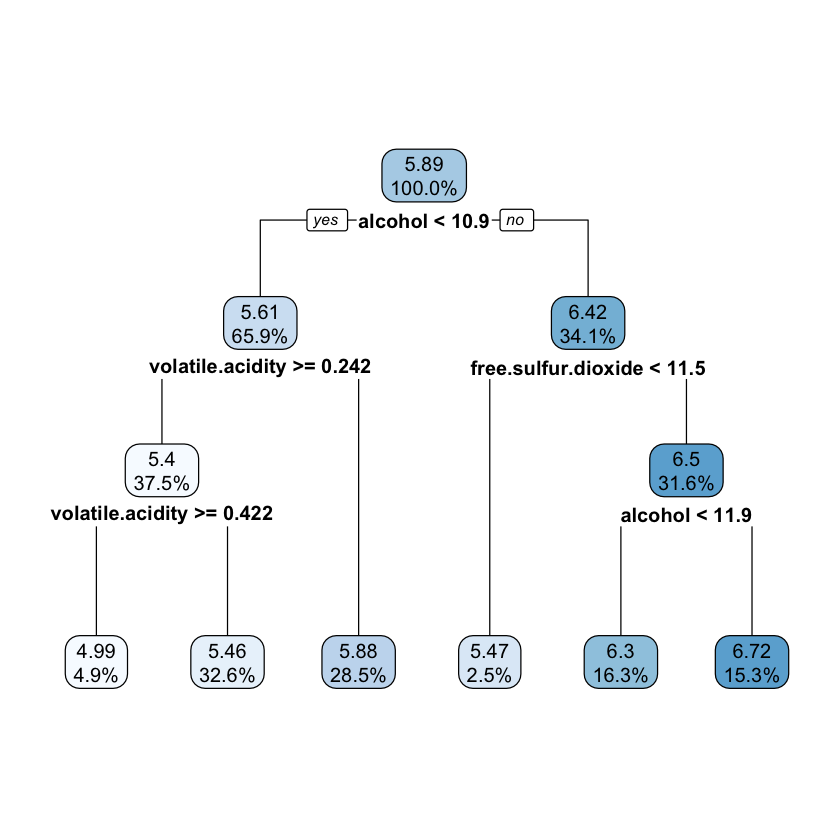

In [8]:
# install.packages("rpart.plot")
library(rpart.plot)
rpart.plot(m.rpart, digits = 3)

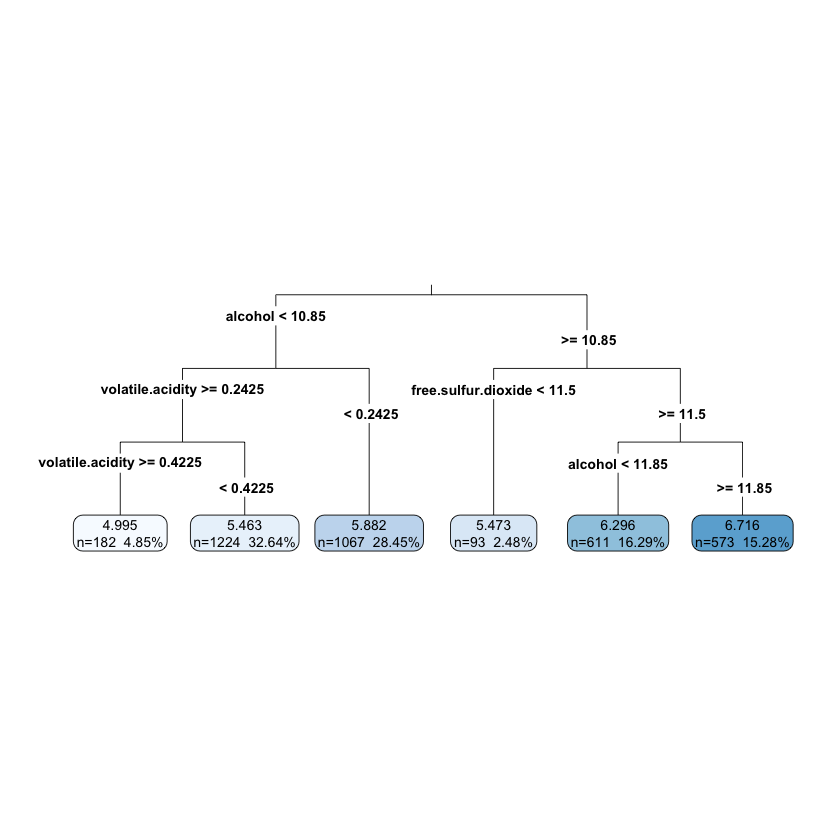

In [9]:
rpart.plot(m.rpart, 
           digits = 4, 
           fallen.leaves = TRUE,
           type = 3, 
           extra = 101)


# Evaluación del modelo

In [10]:
# Pronóstico para la muestra de prueba
p.rpart <- predict(m.rpart, wine_test)

# se compara la distribución de la salida 
# del árbol contra la salida real
summary(p.rpart)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.995   5.463   5.882   5.999   6.296   6.716 

In [11]:
summary(wine_test$quality)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.000   5.000   6.000   5.848   6.000   8.000 

In [12]:
# se define el error medio absoluto para
# evaluar el desempeño del modelo
MAE <- function(actual, predicted) {
    mean(abs(actual - predicted))
}

MAE(p.rpart, wine_test$quality)

[1] 0.5732104

In [13]:
# media de la variable de salida
# para la muestra de entrenamiento
mean(wine_train$quality)

[1] 5.886933

In [14]:
# Valor esperado para el MAE respecto
# a los datos
MAE(5.89, wine_test$quality)

[1] 0.5741115

---

Pronóstico de la popularidad de libros (scikit-learn)
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/predictive-analytics/blob/master/10-logreg-R-books.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/predictive-analytics/blob/master/10-logreg-R-books.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/predictive-analytics/blob/master/LICENSE)  
[Readme](https://github.com/jdvelasq/predictive-analytics/blob/master/readme.md)